### Dataset gazeta.ru
Разберемся с:
- Структурой данных
- Запуском метрик
- Проверкой претренированных моделей

Заюзаем rugpt или похожую модель 

Основана на
https://www.kaggle.com/phoenix120/baseline-summarization

In [1]:
import os
import json
import razdel
from rouge import Rouge

In [2]:
GAZETA_PATH = '../data/gazeta_jsonl'

In [3]:
def read_gazeta_records(file_name, shuffle=False, sort_by_date=True):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle(records)
    return records

In [4]:
dataset_files = {
    'train': os.path.join(GAZETA_PATH,'gazeta_train.jsonl'),
    'val': os.path.join(GAZETA_PATH,'gazeta_val.jsonl'),
    'test': os.path.join(GAZETA_PATH, 'gazeta_test.jsonl')
}

In [5]:
records = {
    split: read_gazeta_records(path) for split, path in dataset_files.items()
}

In [6]:
print(records['val'][0])

{'url': 'https://www.gazeta.ru/sport/2019/05/29/a_12382627.shtml', 'text': 'Будущее капитана московского «Спартака» Дениса Глушакова весь этот сезон находится в подвешенном состоянии, и, похоже, развязка уже близка. Красно-белых ждет серьезная перестройка в летнее трансферное окно, и новому генеральному директору команды Томасу Цорну поставили задачу максимально выгодно расстаться с некоторыми футболистами — в том числе и с 32-летним полузащитником, который ощутимо сдал по игровым кондициям и впал в немилость у большинства фанатов клуба из-за скандальной ссоры с Массимо Каррерой. Однако по контракту у Глушакова еще остается год игры за «Спартак» с зарплатой 3 млн евро в год, как сообщает «СЭ». В случае досрочного расторжения клуб должен будет выплатить футболисту половину этой суммы. И вот тут начинается самое интересное. Адвокат бывшей жены Глушакова Дарьи — Сергей Жорин — заявил, что ему кажется «очень похожей на правду» информация о том, что футболист якобы попросил клуб отдать ему 

In [13]:
def calc_metrics(refs, hyps, metric="all"):
    metrics = dict()
    metrics["count"] = len(hyps)
    metrics["ref_example"] = refs[-1]
    metrics["hyp_example"] = hyps[-1]
#     many_refs = [[r] if r is not list else r for r in refs]
#     if metric in ("bleu", "all"):
#         metrics["bleu"] = corpus_bleu(many_refs, hyps)
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(hyps, refs, avg=True)
        metrics.update(scores)
#     if metric in ("meteor", "all") and meteor_jar is not None and os.path.exists(meteor_jar):
#         meteor = Meteor(meteor_jar, language=language)
#         metrics["meteor"] = meteor.compute_score(hyps, many_refs)
    return metrics

In [102]:
def print_metrics(refs, hyps, metric="all"):
    metrics = calc_metrics(refs, hyps, metric=metric)

    print("-------------METRICS-------------")
    print("Count:\t", metrics["count"])
    print("Ref:\t", metrics["ref_example"])
    print("Hyp:\t", metrics["hyp_example"])

#     if "bleu" in metrics:
#         print("BLEU:     \t{:3.1f}".format(metrics["bleu"] * 100.0))
    if "rouge-1" in metrics:
#         print([metrics["rouge-1"][m] * 100.0 for m in ('p','r','f')])
        print("ROUGE-1: P: {:3.2f} R: {:3.2f} F: {:3.2f}".format(
            *[metrics["rouge-1"][m] * 100.0 for m in ['p','r','f']]))
        print("ROUGE-2: P: {:3.2f} R: {:3.2f} F: {:3.2f}".format(
            *[metrics["rouge-2"][m] * 100.0 for m in ['p','r','f']]))
        print("ROUGE-L: P: {:3.2f} R: {:3.2f} F: {:3.2f}".format(
            *[metrics["rouge-l"][m] * 100.0 for m in ['p','r','f']]))


In [103]:
ms = calc_metrics(
    refs=[records['val'][0]['summary']],
    hyps=[records['val'][0]['summary']]
)

In [104]:
print(ms['rouge-1']['f'])

0.999999995


In [105]:
print_metrics(
    refs=[records['val'][0]['summary']],
    hyps=[records['val'][0]['title']]
)

-------------METRICS-------------
Count:	 1
Ref:	 Адвокат бывшей жены Дениса Глушакова Дарьи — Сергей Жорин — назвал правдоподобной информацию о том, что игрок якобы попросил клуб отдать ему 1,5 млн евро за расторжение контракта наличными, чтобы не платить алименты. Адвокат футболиста Марина Дубровская также высказалась о ситуации.
Hyp:	 Сговор со «Спартаком»? Глушакова винят в уклонении от алиментов
ROUGE-1: P: 11.11 R: 2.44 F: 4.00
ROUGE-2: P: 0.00 R: 0.00 F: 0.00
ROUGE-L: P: 11.11 R: 2.63 F: 4.26


In [106]:
def postprocess(refs, hyps, tokenize_after=True, lower=True):
    for i, (ref, hyp) in enumerate(zip(refs, hyps)):
        ref = ref.strip()
        hyp = hyp.strip()
        if tokenize_after:
            hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
            ref = " ".join([token.text for token in razdel.tokenize(ref)])
        if lower:
            hyp = hyp.lower()
            ref = ref.lower()
        refs[i] = ref
        hyps[i] = hyp
    return refs, hyps

In [107]:
from tqdm.notebook import tqdm

In [168]:
def calc_method_score(records, predict_func, nrows=None, return_ref_pred=False, text_key='text'):
    references = []
    predictions = []

    for i, record in tqdm(enumerate(records)):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record[text_key]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)
    references, predictions = postprocess(references, predictions)
    print_metrics(references, predictions)
    if return_ref_pred:
        return references, predictions

In [109]:
import razdel

def predict_lead(text, summary, n):
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    prediction = " ".join(sentences[:n])
    return prediction

In [113]:
refs, preds = calc_method_score(records['val'], lambda x, y: predict_lead(x, y, 3), return_ref_pred=True)

|          | 0/? [00:00<?, ?it/s]

-------------METRICS-------------
Count:	 5265
Ref:	 в петербурге суд приговорил 16-летнего школьника к 2,5 года воспитательной колонии за то , что он поджег свою 14-летнюю подругу . инцидент произошел ночью , когда группа подростков отдыхала в гостях у приятеля . по версии следствия , юноша облил девочку воспламеняющейся жидкостью и поднес к ней зажигалку . пострадавшая выжила , но получила ожоги 25 % поверхности тела и дыхательных путей .
Hyp:	 в санкт-петербурге суд вынес приговор в отношении 16-летнего подростка , который на вечеринке поджег свою подругу . об этом говорится на сайте следственного управления ск рф по региону . по версии следствия , в ноябре прошлого года группа подростков ночью находилась в квартире одного из друзей .
ROUGE-1: P: 30.81 R: 37.00 F: 32.42
ROUGE-2: P: 12.85 R: 15.90 F: 13.68
ROUGE-L: P: 27.10 R: 31.39 F: 28.27


In [114]:
preds = prefs
del prefs

In [115]:
print(preds[:4])

['будущее капитана московского « спартака » дениса глушакова весь этот сезон находится в подвешенном состоянии , и , похоже , развязка уже близка . красно-белых ждет серьезная перестройка в летнее трансферное окно , и новому генеральному директору команды томасу цорну поставили задачу максимально выгодно расстаться с некоторыми футболистами — в том числе и с 32-летним полузащитником , который ощутимо сдал по игровым кондициям и впал в немилость у большинства фанатов клуба из-за скандальной ссоры с массимо каррерой . однако по контракту у глушакова еще остается год игры за « спартак » с зарплатой 3 млн евро в год , как сообщает « сэ » .', 'сенаторы соединенных штатов предлагают ввести пять видов санкционных ограничений против тех , кто страхует суда , укладывающие « северный поток — 2 » . об этом сообщается на сайте конгресса . « президент может ввести пять или более санкций … в отношении иностранного лица , если он решит , что это лицо осознанно в дату вступления этого закона в силу ил

In [116]:
print(refs[:4])

['адвокат бывшей жены дениса глушакова дарьи — сергей жорин — назвал правдоподобной информацию о том , что игрок якобы попросил клуб отдать ему 1,5 млн евро за расторжение контракта наличными , чтобы не платить алименты . адвокат футболиста марина дубровская также высказалась о ситуации .', 'ни много ни мало , а пять видов санкций предлагают ввести сша против участвующих в российском проекте « северный поток — 2 » . замешанным в сп — 2 запретят любые финансовые операции , в том числе выдачу кредитов . взамен российского газа сша продвигают « молекулы свободы » — свой сжиженный природный газ .', 'в здании муниципалитета города вирджиния-бич на восточном побережье сша 40-летний местный житель открыл стрельбу в муниципалитете . погибли 12 человек . сам стрелок скончался из-за ранений , полученных в ходе длительной перестрелки с четверыми полицейскими . по словам правоохранителей , причиной акта агрессии было недовольство крэддока работой муниципальных органов .', 'прославленная фигуристка

## Собственная реализация LexRank

In [117]:
import lexrank_rus

In [119]:
# lemmatized_sentences = {
#     split: lexrank_rus.get_lemmatized_sentences([rec['text'] for rec in recs]) 
#     for split, recs in records.items()
# }

In [176]:
import numpy as np

In [177]:
import random

In [178]:
training_sentences = lexrank_rus.get_lemmatized_sentences(
    random.sample([rec['text'] for rec in records['train']],10_000))

100%|██████████| 10000/10000 [03:10<00:00, 52.51it/s]


In [179]:
lemmatized, original = training_sentences

In [181]:
from typing import List

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [185]:
def train_tfidf(concatenated_sentences: List[List[str]]):
    vectorizer = TfidfVectorizer(preprocessor=lambda s:s,
                                 tokenizer=lambda s:s,
                                 lowercase=False,
                                 max_df=0.4,min_df=5,
                                 max_features=20_000)
    return vectorizer.fit(concatenated_sentences)


In [186]:
tfidf_vectorizer = train_tfidf([s for text in lemmatized for s in text])

/home/ivan/Programming/Python/general37/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [187]:
small_val_sample = random.sample(records['val'],100)

In [188]:
val_lemmatized, val_original = lexrank_rus.get_lemmatized_sentences(
    [rec['text'] for rec in small_val_sample]
)

100%|██████████| 100/100 [00:02<00:00, 41.78it/s]


In [189]:
TEXT_INDEX=0

In [190]:
print(val_original[TEXT_INDEX])

['Российские самолеты Военно-космических сил (ВКС) нанесли четыре бомбовых удара по террористам в Идлибе, сообщили в Минобороны.', '«В результате в районах населенного пункта Докмак и высоты Джебель-Таверта уничтожены крупные скопления боевиков и позиции полевой артиллерии, с которых осуществлялся обстрел турецкого наблюдательного поста», — цитирует РИА «Новости» заявление ведомства.', 'В министерстве добавили, что тесное сотрудничество российского и турецкого командований в Сирии в рамках борьбы с террористическими группировками будет продолжено.', 'Это произошло после того, как турецкое командование попросило российскую сторону о помощи в обеспечении безопасности военнослужащих и принятии ответных мер в отношении террористов.', 'Отметим, что Анкара предоставила ВКС России координаты для атаки.', 'Ранее террористы-союзники «Джебхат ан-Нусры» (террористическая организация, запрещенная в России) напали на наблюдательный пост турецкой армии.', 'Инцидент произошел, несмотря на то что днем

In [191]:
print(val_lemmatized[TEXT_INDEX])

[['российский', 'самолет', 'военный', 'космический', 'сила', 'ВКС', 'наносить', 'четыре', 'бомбовый', 'удар', 'по', 'террорист', 'в', 'идлиба', 'сообщать', 'в', 'минобороны'], ['в', 'результат', 'в', 'район', 'населять', 'пункт', 'докмак', 'и', 'высота', 'джебель', 'таверт', 'уничтожать', 'крупный', 'скопление', 'боевик', 'и', 'позиция', 'полевой', 'артиллерия', 'с', 'который', 'осуществляться', 'обстрел', 'турецкий', 'наблюдательный', 'пост', 'цитировать', 'риа', 'новость', 'заявление', 'ведомство'], ['в', 'министерство', 'добавлять', 'что', 'тесный', 'сотрудничество', 'российский', 'и', 'турецкий', 'командование', 'в', 'сирия', 'в', 'рамка', 'борьба', 'с', 'террористический', 'группировка', 'быть', 'продолжать'], ['это', 'происходить', 'после', 'то', 'как', 'турецкий', 'командование', 'попросить', 'российский', 'сторона', 'о', 'помощь', 'в', 'обеспечение', 'безопасность', 'военнослужащий', 'и', 'принятие', 'ответный', 'мера', 'в', 'отношение', 'террорист'], ['отмечать', 'что', 'анкар

In [192]:
sims = lexrank_rus.compute_tfidf_similarity_matrix(val_lemmatized[TEXT_INDEX], tfidf_vectorizer)

In [193]:
sims

array([[1.        , 0.        , 0.02929126, ..., 0.        , 0.03133671,
        0.        ],
       [0.        , 1.        , 0.07909801, ..., 0.        , 0.01552051,
        0.02048675],
       [0.02929126, 0.07909801, 1.        , ..., 0.01603328, 0.08490457,
        0.07104885],
       ...,
       [0.        , 0.        , 0.01603328, ..., 1.        , 0.16537371,
        0.        ],
       [0.03133671, 0.01552051, 0.08490457, ..., 0.16537371, 1.        ,
        0.05492265],
       [0.        , 0.02048675, 0.07104885, ..., 0.        , 0.05492265,
        1.        ]])

In [194]:
M_pr = lexrank_rus.get_pagerank_matrix(sims, 0.85, zero_diag=True)

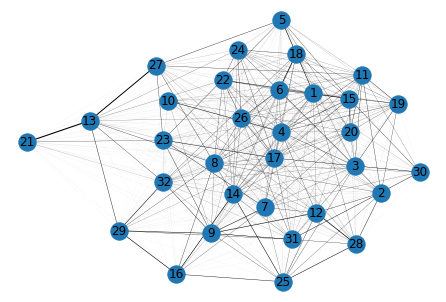

In [195]:
lexrank_rus.draw_sentence_graph(M_pr)

In [196]:
pagerank_scores = lexrank_rus.power_iter(M_pr,1_000, 0.0000001)

In [197]:
pagerank_rankings = (-pagerank_scores).argsort()

In [198]:
print(small_val_sample[TEXT_INDEX]['title'])

Боевики уничтожены: ВКС России атаковали террористов в Идлибе


In [199]:
print(small_val_sample[TEXT_INDEX]['summary'])

Российские самолеты нанесли четыре бомбовых удара по боевикам в Идлибе. Военнослужащие уничтожили несколько скоплений террористов, а также их позиции, с которых они вели обстрел наблюдательного поста Турции. Это была ответная мера на действия боевиков, которые ранее атаковали турецких военных, чем нарушили «режим тишины», введенный 12 июня.


In [200]:
for i in pagerank_rankings:
    print(i+1, np.round(pagerank_scores[i],3), val_original[TEXT_INDEX][i])

17 0.049 Глава российского МИДа Сергей Лавров заявил 10 июня, что поблажек террористам не будет, и ситуация будет урегулирована.
8 0.048 «Ночью 13 июня 2019 года террористы обстреляли из артиллерийских орудий наблюдательный пост вооруженных сил Турции, расположенный в районе высоты Джебель-Завия провинции Идлиб», — приводит ФАН слова сообщения Минобороны.
6 0.048 Ранее террористы-союзники «Джебхат ан-Нусры» (террористическая организация, запрещенная в России) напали на наблюдательный пост турецкой армии.
9 0.046 В ночь с 11 на 12 июня, по данным агентства, на территории Идлибской зоны деэскалации в Сирии вступил в силу режим прекращения огня.
14 0.043 Он остается последней провинцией в Сирии, которая находится под контролем террористов.
4 0.042 Это произошло после того, как турецкое командование попросило российскую сторону о помощи в обеспечении безопасности военнослужащих и принятии ответных мер в отношении террористов.
26 0.042 Так, 10 июня террористы напали на два блокпоста сирийск

In [201]:
test_lemmatized, test_original = lexrank_rus.get_lemmatized_sentences([r['text'] for r in records['test']])

100%|██████████| 5770/5770 [01:48<00:00, 53.39it/s]


In [202]:
test_original[0]

['В октябре 2019 года в России вступают в силу ряд новаций, которые существенно затрагивают интересы россиян.',
 'Итак, с 1 числа ожидается повышение зарплат работникам бюджетной сферы.',
 'Тех бюджетников, которые не затронуты майскими указами президента.',
 'Повышение коснется персонала детских садов (нянечек), юристов, бухгалтеров, технических работников и социальных психологов.',
 'Прибавку получат также военные, сотрудники органов внутренних дел , уголовно-исполнительной системы наказаний, служащие национальной гвардии.',
 'У работников учреждений, не относящихся к социальной сфере и науке, зарплаты будут повышены на 3,8%.',
 'Эта новация затронет трудящихся в МЧС , гидробиологов, океанологов, метеорологов, работников селекционно-семеноводческих центров, ветеринарной службы, лесников и многих других.',
 'Окончательное решение о размерах зарплат и повышающих надбавок будет приниматься на региональном уровне.',
 'Также в октябре в 1,043 раза увеличат оклады сотрудникам МИД и другим 

In [203]:
def predict_custom_lexrank(x, summaries, vectorizer, n_sentences_in_summary=1):
    lemmatized_sentences = test_lemmatized[x]
    original_sentences = test_original[x]
    
    mtr = lexrank_rus.compute_tfidf_similarity_matrix(lemmatized_sentences, vectorizer)
    mpr = lexrank_rus.get_pagerank_matrix(mtr,0.85,zero_diag=True)
    scores = lexrank_rus.power_iter(mpr, 1000, 0.0000001)
    ranks = (-scores).argsort()
    
    selected_sentences = [original_sentences[i] for i in ranks[:n_sentences_in_summary]]
    summary = ' '.join(selected_sentences)
    return summary

In [204]:
test_set_for_custom_lexrank = [
    {
        'summary': rec['summary'],
        'pos': i,
    } for i, rec in enumerate(records['test'])
]

In [205]:
test_set_for_custom_lexrank[:2]

[{'summary': 'Октябрь богат на изменения в законодательстве. В бюджетной сфере с 1 октября повысят зарплаты. Заемщикам снизят показатель предельной долговой нагрузки, при которой возможна выдача кредита. Запретят курить на балконах и в отелях. И введут 20%-й налог на пальмовое масло, чтобы кондитеры меньше травили россиян.',
  'pos': 0},
 {'summary': 'С 1 октября кредитор, принимая решение о выдаче клиенту кредита или займа, обязан учитывать показатель его долговой нагрузки. В итоге банки и МФО станут чаще отказывать в выдаче денег. С одной стороны, люди не попадут в долговую яму. С другой — перехватить небольшие средства на самые необходимые траты будет еще сложнее.',
  'pos': 1}]

In [206]:
calc_method_score(
    test_set_for_custom_lexrank, 
    lambda x,y: predict_custom_lexrank(x, y, tfidf_vectorizer,n_sentences_in_summary=3),text_key='pos'
)

|          | 0/? [00:00<?, ?it/s]

/home/ivan/Programming/ML/Summarization/Samsung/lexrank_rus.py:51: RuntimeWarning: invalid value encountered in true_divide
  sims = similarity_matrix / similarity_matrix.sum(axis=1, keepdims=True)


-------------METRICS-------------
Count:	 5770
Ref:	 канцлер германии ангела меркель , будучи на домашнем карантине , сдала первый тест на коронавирус , который дал отрицательный результат . 65-летняя политик решила самоизолироваться после того , как оказалось , что у врача , с которым она контактировала , обнаружили инфекцию . в настоящее время она продолжает выполнять свои обязанности по видеосвязи .
Hyp:	 « результат теста , который был сделан сегодня , отрицательный » , — отметил он . канцлер германии ангела меркель сдала первый тест на наличие коронавируса . после того как стало известно о первых зараженных из делегации , трамп сдал тест , который дал отрицательный результат .
ROUGE-1: P: 22.13 R: 32.24 F: 25.43
ROUGE-2: P: 6.70 R: 10.06 F: 7.80
ROUGE-L: P: 19.23 R: 25.12 F: 21.20


In [207]:
calc_method_score(
    test_set_for_custom_lexrank[5:6], 
    lambda x,y: predict_custom_lexrank(x, y, tfidf_vectorizer,n_sentences_in_summary=3),text_key='pos'
)

|          | 0/? [00:00<?, ?it/s]

-------------METRICS-------------
Count:	 1
Ref:	 на компенсации чиновникам при сокращении в ближайшие три года потратят 4,8 млрд рублей . об этом сообщает газета « известия » со ссылкой на минфин . речь , по данным агентства акра , может идти об увольнении 13 тысяч человек . массовые сокращения чиновников в минфине обосновывают необходимостью поднять зарплату до конкурентного уровня остальным . впрочем , она и так почти в три раза больше , чем в среднем по стране .
Hyp:	 волну сокращения чиновников уже не раз анонсировали в минфине . данные о том , сколько чиновников в россии , у минфина и росстата расходятся . при этом , согласно подсчетам аналитического кредитного рейтингового агентства ( акра ) , при средней зарплате федерального чиновника в 127 тысяч рублей и выплате трех окладов при увольнении речь идет о сокращении порядка 13 тысяч человек .
ROUGE-1: P: 37.29 R: 32.84 F: 34.92
ROUGE-2: P: 8.62 R: 7.58 F: 8.06
ROUGE-L: P: 29.17 R: 24.56 F: 26.67
